In [55]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight

from sklearn.metrics import classification_report, confusion_matrix
import zipfile, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(tf.__version__)


2.10.1


In [56]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:", len(gpus))
else:
    print("No GPUs available.")

Available GPUs: 1


In [57]:
base_dir = 'chest'
train_dir = 'chest/train'
test_dir = 'chest/test'
val_dir = 'chest/val'
os.listdir(base_dir)

['test', 'train', 'val']

In [58]:
img_width, img_height = 224, 224
batch_size = 128

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)


Found 4204 images belonging to 2 classes.
Found 1052 images belonging to 2 classes.


In [59]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 2.0487329434697856, 1: 0.6614222781623663}

In [60]:
densenet201 = DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in densenet201.layers:
    layer.trainable = False

# x = densenet201.output
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# pred = layers.Dense(1, activation='sigmoid')(x)

x = densenet201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
pred = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=densenet201.input, outputs=pred)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [61]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', save_best_only=True, mode='max', verbose=1)

In [62]:
epochs=50

hist = model.fit(train_generator,
                 epochs=epochs,
                 validation_data=val_generator,
                 callbacks=[early_stopping, reduce_lr, model_checkpoint],
                 class_weight=class_weight_dict
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 3.1238 - binary_accuracy: 0.7419
Epoch 1: val_binary_accuracy improved from -inf to 0.89639, saving model to best_model.h5
33/33 [==============================] - 104s 3s/step - loss: 3.1238 - binary_accuracy: 0.7419 - val_loss: 1.5357 - val_binary_accuracy: 0.8964 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.1894 - binary_accuracy: 0.8820
Epoch 2: val_binary_accuracy did not improve from 0.89639
33/33 [==============================] - 83s 3s/step - loss: 1.1894 - binary_accuracy: 0.8820 - val_loss: 1.0291 - val_binary_accuracy: 0.8441 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.8011 - binary_accuracy: 0.9068
Epoch 3: val_binary_accuracy did not improve from 0.89639
33/33 [==============================] - 85s 3s/step - loss: 0.8011 - binary_accuracy: 0.9068 - val_loss: 0.7721 - val_binary_accuracy: 0.8698 - lr: 0.0010
Epoch 4/50
33/33 [====

In [63]:
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc}')

9/9 [==============================] - 11s 1s/step - loss: 0.2207 - binary_accuracy: 0.9316
Test accuracy: 0.9315589070320129


In [64]:
hist_= pd.DataFrame(hist.history)
hist_

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,3.123797,0.741912,1.535739,0.896388,0.00100
1,1.189365,0.882017,1.029069,0.844106,0.00100
2,0.801143,0.906755,0.772144,0.869772,0.00100
3,0.638268,0.911275,0.705646,0.846958,0.00100
4,0.523167,0.914605,0.528799,0.889734,0.00100
5,0.448012,0.918887,0.543975,0.863118,0.00100
6,0.390667,0.928164,0.451133,0.889734,0.00100
7,0.360690,0.924596,0.394820,0.900190,0.00100
8,0.325873,0.931018,0.429634,0.877376,0.00100
9,0.319218,0.921741,0.369276,0.896388,0.00100


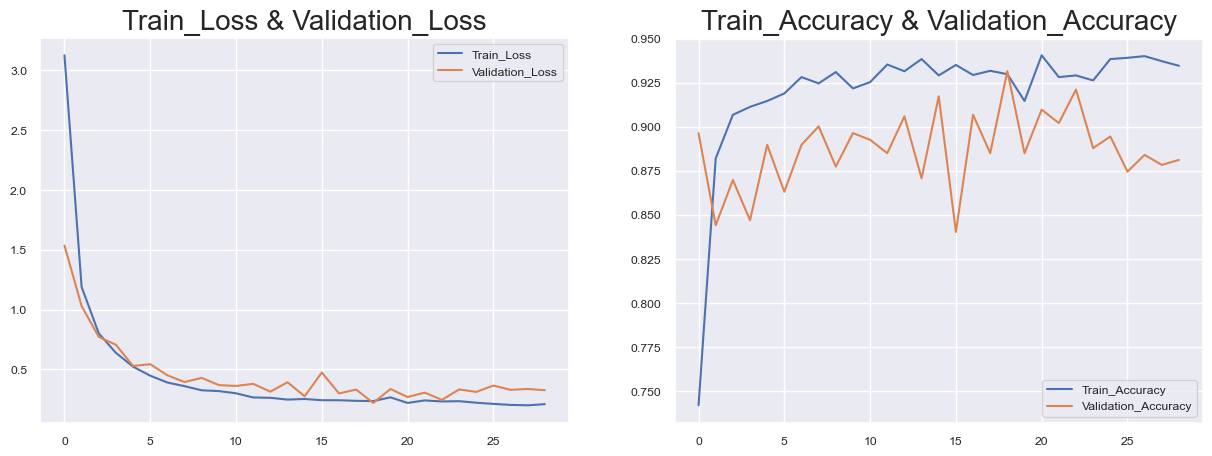

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['binary_accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_binary_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [66]:
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 600 images belonging to 2 classes.


In [67]:
y_pred = model.predict(test_generator)

5/5 [==============================] - 17s 3s/step


In [68]:
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

In [69]:
classification_rep = classification_report(y_true, y_pred_binary, target_names=['Normal', 'Pneumonia'])
confusion_mat = confusion_matrix(y_true, y_pred_binary)

print("Classification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", confusion_mat)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.93      0.98      0.95       300
   Pneumonia       0.98      0.93      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600


Confusion Matrix:
 [[293   7]
 [ 21 279]]


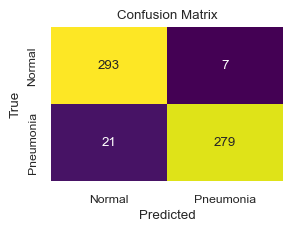

In [70]:
plt.figure(figsize=(3, 2))
sns.set(font_scale=0.8)
sns.heatmap(confusion_mat, annot=True, cmap='viridis', cbar=False, fmt='d', 
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
model.save('pneumonia_densenet201.h5')

1/1 [==============================] - 4s 4s/step
chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg
Image classified as Pneumonia
[0.99277025]


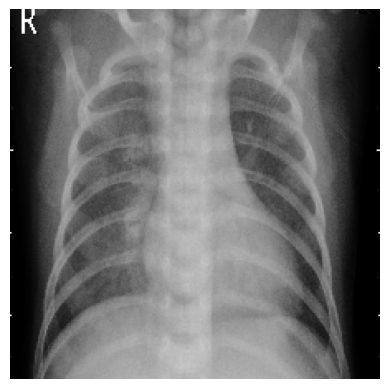

In [72]:
# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = fn
img = image.load_img('chest/val/PNEUMONIA/person74_virus_135.jpeg', target_size=(224,224,3))

imgplot = plt.imshow(img)
plt.axis('off')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
images = np.vstack([x])

classes = model.predict(images)
print('chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg')
if classes[0] > 0.5:
  print('Image classified as Pneumonia')
else:
  print('Image classified as Normal')
print(classes[0])